# Tutorial

> The goal of this challenge is to find all instances of dolphins in a picture and then color pixes of each dolphin with a unique color.

Please open this notebook in Colab to edit it and submit a solution:
    
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cro-ai-league/dolphins-recognition-challenge/blob/master/notebooks/00_Tutorial.ipynb)

In [ ]:
try:
    import dolphins_recognition_challenge
except Exception:
    if "google.colab" in str(get_ipython()):
        print("Running on CoLab")
        !pip install dolphins-recognition-challenge

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import PIL
from PIL import Image

import torch
import torchvision
import pandas as pd
import seaborn as sns

## Download data

We start by downloading and visualizing the dataset containing 200 photographs with one or more dolphins split into a training set containing 160 photographs and a validation set containing 40 photographs.

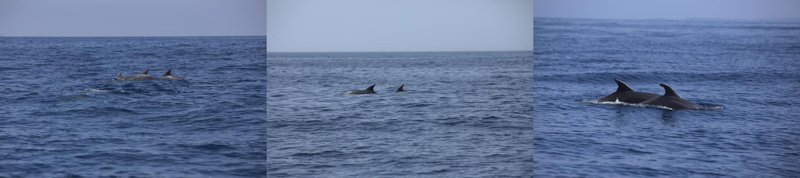

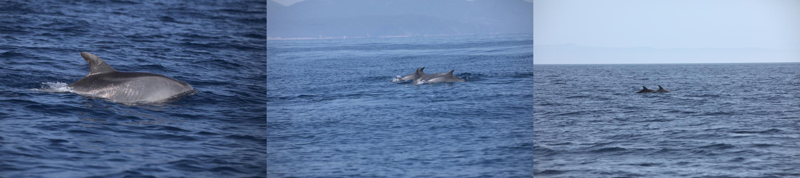

In [ ]:
from dolphins_recognition_challenge.datasets import get_dataset, display_batches
    
data_loader, data_loader_test = get_dataset("segmentation", batch_size=3)

display_batches(data_loader, n_batches=2)

## Data augmentation

In order to prevent overfitting which happens when the dataset size is too small, we perform a number of transformations to increase the size of the dataset. One transofrmation implemented in the Torch vision library is `RandomHorizontalFlip` and we will implemented `MyColorJitter` which is basically just a wrapper around `torchvision.transforms.ColorJitter` class. However, we cannot use this class directly without a wrapper because a transofrmation could possibly affect targets and not just the image. For example, if we were to implement RandomCrop, we would need to crop segmentation masks and readjust bounding boxes as well.

In [ ]:
class MyColorJitter:
    def __init__(self, brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5):
        self.torch_color_jitter = torchvision.transforms.ColorJitter(
            brightness=brightness, contrast=contrast, saturation=saturation, hue=hue
        )

    def __call__(self, image, target):
        image = self.torch_color_jitter(image)
        return image, target

We will make a series of transformations on an image and we will combine all those transofrmations in a single one as follows:

In [ ]:
from dolphins_recognition_challenge.datasets import ToTensor, ToPILImage, Compose, RandomHorizontalFlip

def get_tensor_transforms(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(
            MyColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
        )
        transforms.append(RandomHorizontalFlip(0.5))
        # TODO: add additional transforms: e.g. random crop
    return Compose(transforms)

With data augementation defined, we are ready to generate the actual datasets used for training our models.

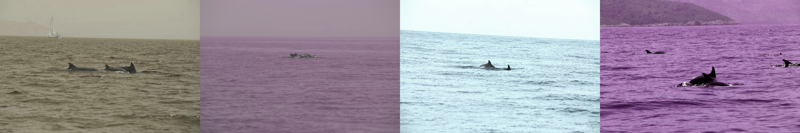

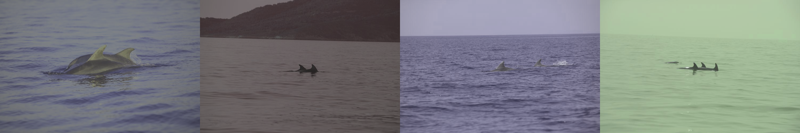

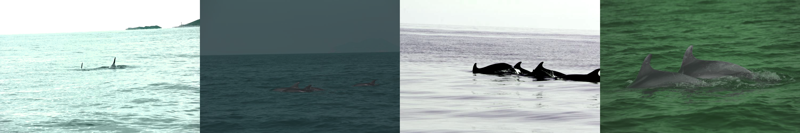

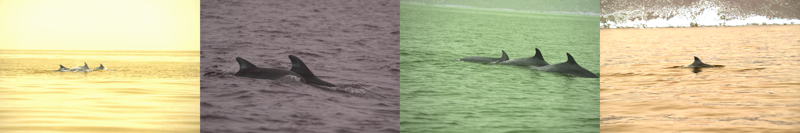

In [ ]:
batch_size = 4

data_loader, data_loader_test = get_dataset(
    "segmentation", get_tensor_transforms=get_tensor_transforms, batch_size=batch_size
)

display_batches(data_loader, n_batches=4)

> Tip: incorporate more transformation classes such as RandomCrop etc. (https://pytorch.org/docs/stable/torchvision/transforms.html)

## Model

We can reuse already trained models for instance segmentation trained on other dataset and finetune it for our particular problem, in our case on dataset with dolphins.

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_instance_segmentation_model(hidden_layer_size, box_score_thresh=0.5):
    # our dataset has two classes only - background and dolphin    
    num_classes = 2
    
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(
        pretrained=True, 
        box_score_thresh=box_score_thresh, 
    )

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_channels=in_features_mask, 
        dim_reduced=hidden_layer_size,
        num_classes=num_classes
    )

    return model

Before using a model constructed, we should move it to appropriate device. We will test if we have GPU available and move it to there if possible.

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# get the model using our helper function
model = get_instance_segmentation_model(hidden_layer_size=256)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

We have implemented a function for training a model for one epoch - meaning using each image from the training dataset exactly once. Let's train for one epochs an see what predictions we make before and after that.

In [ ]:
# used for automatic testing only
data_loader, data_loader_test = get_dataset(
    "segmentation",
    batch_size=4,
    get_tensor_transforms=get_tensor_transforms,
    n_samples=8,
)

In [ ]:
data_loader, data_loader_test = get_dataset(
    "segmentation", get_tensor_transforms=get_tensor_transforms, batch_size=batch_size
)

/root/.local/lib/python3.6/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Epoch: [0]  [ 0/40]  eta: 0:01:20  lr: 0.000133  loss: 4.0365 (4.0365)  loss_classifier: 0.7135 (0.7135)  loss_box_reg: 0.2773 (0.2773)  loss_mask: 3.0243 (3.0243)  loss_objectness: 0.0091 (0.0091)  loss_rpn_box_reg: 0.0124 (0.0124)  time: 2.0047  data: 1.1275  max mem: 4477
Epoch: [0]  [20/40]  eta: 0:00:14  lr: 0.002695  loss: 0.9883 (1.4917)  loss_classifier: 0.2163 (0.2969)  loss_box_reg: 0.2675 (0.2757)  loss_mask: 0.3774 (0.8357)  loss_objectness: 0.0129 (0.0390)  loss_rpn_box_reg: 0.0197 (0.0443)  time: 0.6811  data: 0.0102  max mem: 4756
Epoch: [0]  [39/40]  eta: 0:00:00  lr: 0.005000  loss: 0.6886 (1.0935)  loss_classifier: 0.1147 (0.2084)  loss_box_reg: 0.2390 (0.2614)  loss_mask: 0.2367 (0.5609)  loss_objectness: 0.0106 (0.0255)  loss_rpn_box_reg: 0.0145 (0.0372)  time: 0.6678  data: 0.0102  max mem: 5186
Epoch: [0] Total time: 0:00:28 (0.7101 s / it)
Epoch: [1]  [ 0/40]  eta: 0:01:16  lr: 0.005000  loss: 0.5957 (0.5957)  loss_classifier: 0.0515 (0.0515)  loss_box_reg: 0.156

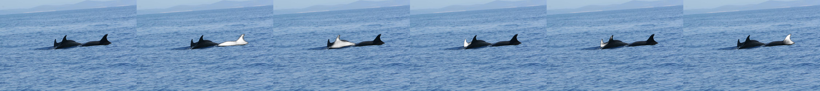

In [ ]:
from dolphins_recognition_challenge.instance_segmentation.model import train_one_epoch
from dolphins_recognition_challenge.instance_segmentation.model import show_predictions

show_predictions(model, data_loader=data_loader_test, n=1, score_threshold=0.5)

num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch=epoch, print_freq=20)

train_one_epoch(model, optimizer, data_loader, device, epoch=1, print_freq=20)

show_predictions(model, data_loader=data_loader_test, n=1, score_threshold=0.5)

Now we can fully train the model for more epochs, in this case for 20 more.

In [ ]:
num_epochs = 20

data_loader, data_loader_test = get_dataset(
    "segmentation", batch_size=4, get_tensor_transforms=get_tensor_transforms
)

In [ ]:
for epoch in range(1, num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch=epoch, print_freq=20)

    lr_scheduler.step()

Epoch: [1]  [ 0/40]  eta: 0:01:13  lr: 0.005000  loss: 0.3240 (0.3240)  loss_classifier: 0.0630 (0.0630)  loss_box_reg: 0.1141 (0.1141)  loss_mask: 0.1316 (0.1316)  loss_objectness: 0.0045 (0.0045)  loss_rpn_box_reg: 0.0107 (0.0107)  time: 1.8457  data: 1.1334  max mem: 5186
Epoch: [1]  [20/40]  eta: 0:00:15  lr: 0.005000  loss: 0.3992 (0.4196)  loss_classifier: 0.0662 (0.0715)  loss_box_reg: 0.1295 (0.1393)  loss_mask: 0.1815 (0.1859)  loss_objectness: 0.0056 (0.0075)  loss_rpn_box_reg: 0.0141 (0.0155)  time: 0.6964  data: 0.0127  max mem: 5186
Epoch: [1]  [39/40]  eta: 0:00:00  lr: 0.005000  loss: 0.3979 (0.4282)  loss_classifier: 0.0654 (0.0714)  loss_box_reg: 0.1271 (0.1398)  loss_mask: 0.1731 (0.1836)  loss_objectness: 0.0047 (0.0076)  loss_rpn_box_reg: 0.0075 (0.0257)  time: 0.6889  data: 0.0110  max mem: 5186
Epoch: [1] Total time: 0:00:28 (0.7232 s / it)
Epoch: [2]  [ 0/40]  eta: 0:01:13  lr: 0.005000  loss: 0.4541 (0.4541)  loss_classifier: 0.0680 (0.0680)  loss_box_reg: 0.125

Epoch: [10]  [39/40]  eta: 0:00:00  lr: 0.005000  loss: 0.2614 (0.2522)  loss_classifier: 0.0347 (0.0353)  loss_box_reg: 0.0748 (0.0752)  loss_mask: 0.1176 (0.1273)  loss_objectness: 0.0017 (0.0019)  loss_rpn_box_reg: 0.0070 (0.0124)  time: 0.6966  data: 0.0101  max mem: 5187
Epoch: [10] Total time: 0:00:29 (0.7323 s / it)
Epoch: [11]  [ 0/40]  eta: 0:01:24  lr: 0.000500  loss: 0.1697 (0.1697)  loss_classifier: 0.0359 (0.0359)  loss_box_reg: 0.0517 (0.0517)  loss_mask: 0.0787 (0.0787)  loss_objectness: 0.0018 (0.0018)  loss_rpn_box_reg: 0.0017 (0.0017)  time: 2.1095  data: 1.3535  max mem: 5187
Epoch: [11]  [20/40]  eta: 0:00:15  lr: 0.000500  loss: 0.2105 (0.2454)  loss_classifier: 0.0323 (0.0345)  loss_box_reg: 0.0632 (0.0692)  loss_mask: 0.1108 (0.1198)  loss_objectness: 0.0010 (0.0013)  loss_rpn_box_reg: 0.0045 (0.0206)  time: 0.7076  data: 0.0092  max mem: 5187
Epoch: [11]  [39/40]  eta: 0:00:00  lr: 0.000500  loss: 0.2302 (0.2438)  loss_classifier: 0.0310 (0.0353)  loss_box_reg: 

## Calculate metrics

Visualise few samples and print the IOU metric for those samples 

IOU metric for the input image is: 0.611417860986359


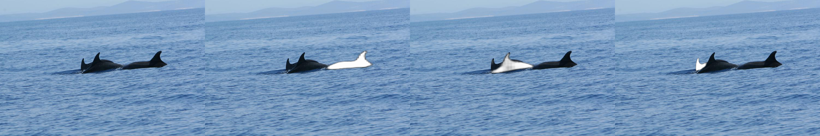

IOU metric for the input image is: 0.6266646179274642


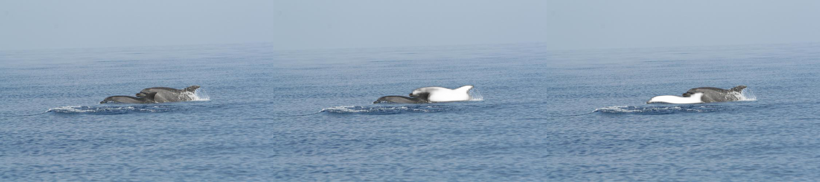

IOU metric for the input image is: 0.49453726340315735


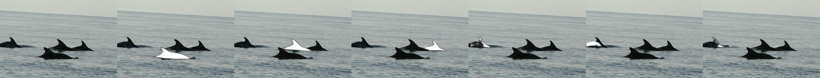

IOU metric for the input image is: 0.5125102391690628


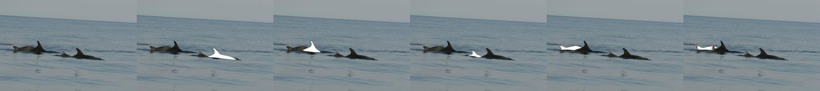

In [ ]:
from dolphins_recognition_challenge.instance_segmentation.model import show_prediction, iou_metric_example

for i in range(4):
    iou_test_image = iou_metric_example(model, data_loader_test.dataset[i], 0.5)
    img, _ = data_loader_test.dataset[i]
    print(f"IOU metric for the input image is: {iou_test_image}")
    show_prediction(model, img, width=820)


Calculate the mean IOU metric for the entire data set

In [ ]:
%%time

from dolphins_recognition_challenge.instance_segmentation.model import iou_metric, show_predictions_sorted_by_iou

mean_iou_testset, _ = iou_metric(model, data_loader_test.dataset)

print(f"Mean IOU metric for the test set is: {mean_iou_testset}")

Mean IOU metric for the test set is: 0.4572200769277805
CPU times: user 11.1 s, sys: 21.2 ms, total: 11.1 s
Wall time: 7.1 s


...

IOU metric: 0.21098597787540233


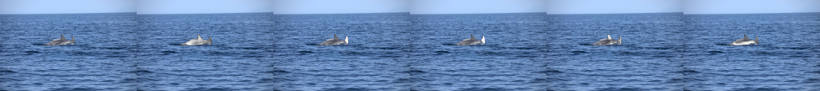

IOU metric: 0.2232096224908163


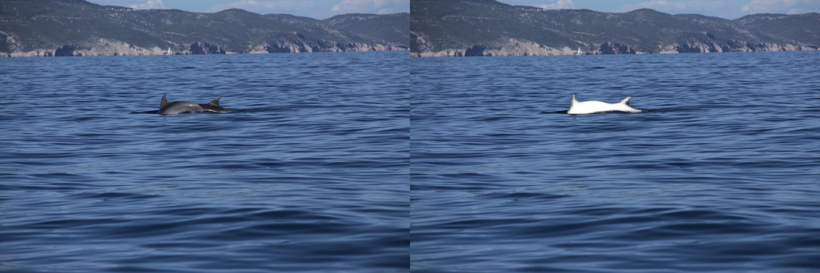

IOU metric: 0.2512907010096409


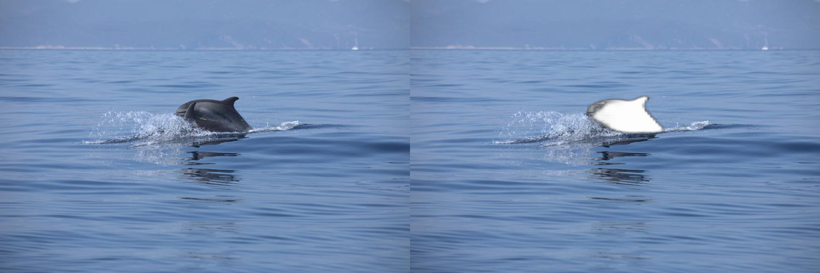

IOU metric: 0.2766092920159012


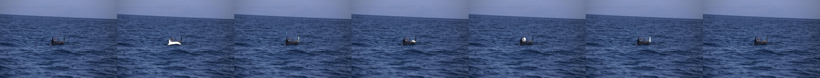

IOU metric: 0.31027277114326873


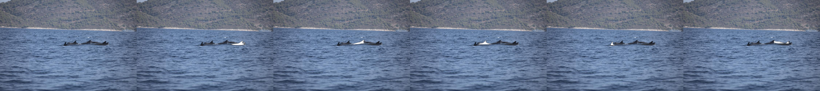

IOU metric: 0.3237450562303182


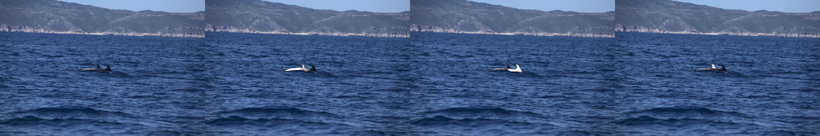

IOU metric: 0.33076757255564115


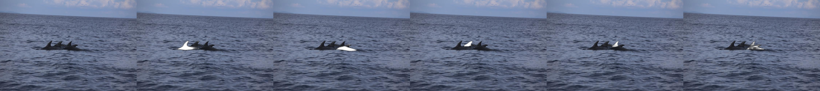

IOU metric: 0.33328621638503103


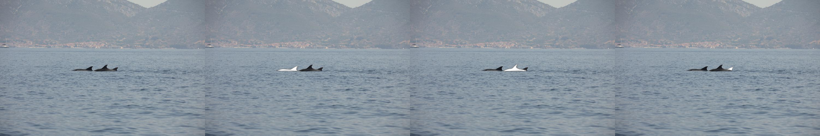

IOU metric: 0.36783285284834627


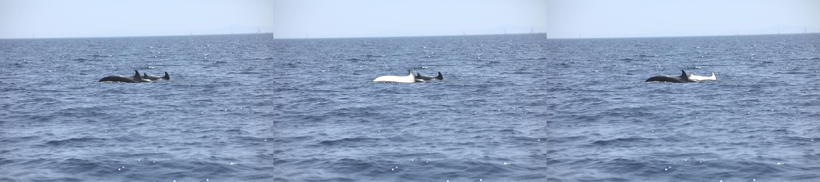

IOU metric: 0.3693530331366992


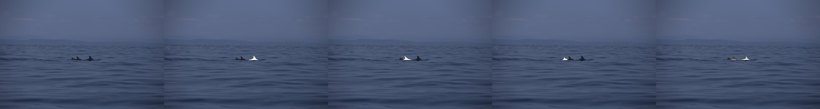

IOU metric: 0.3765179274671962


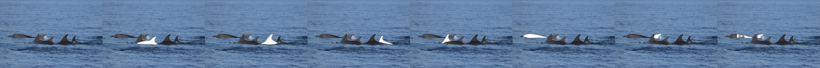

IOU metric: 0.37857096487455416


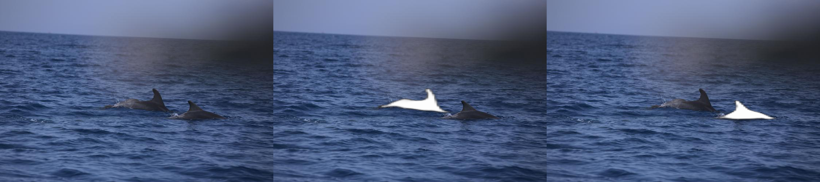

IOU metric: 0.391026799403781


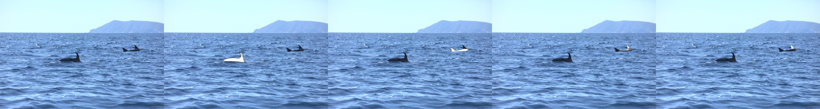

IOU metric: 0.39555250206320397


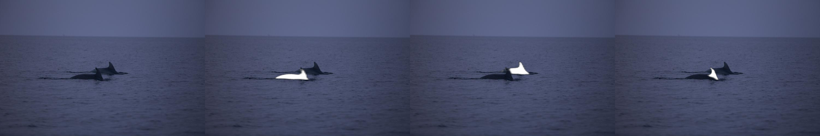

IOU metric: 0.3962583467560526


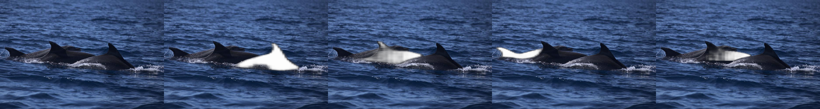

IOU metric: 0.40203977087818266


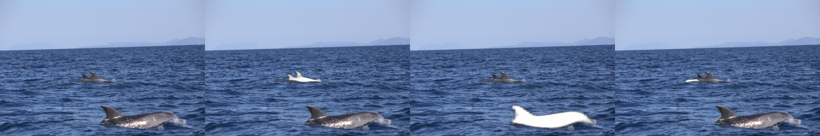

IOU metric: 0.4181012870137721


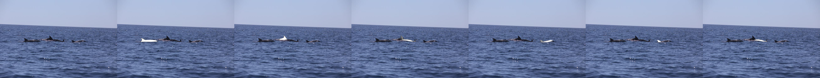

IOU metric: 0.4206897893475901


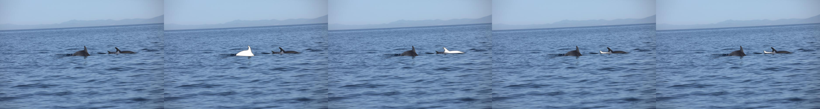

IOU metric: 0.43016028679887897


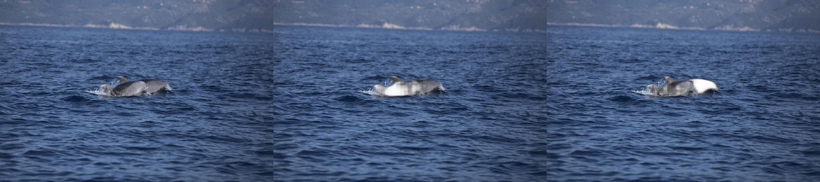

IOU metric: 0.4385907676718781


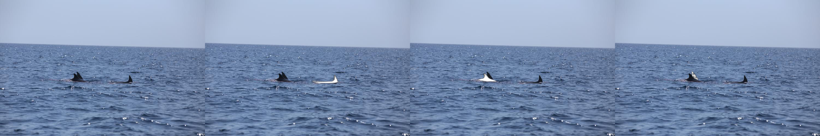

IOU metric: 0.45471250788992856


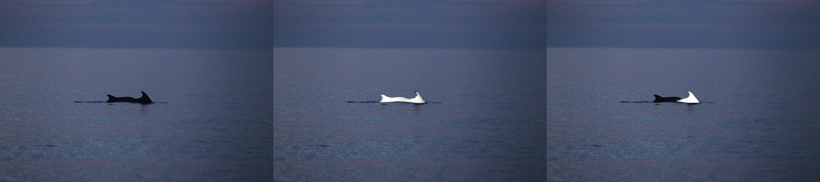

IOU metric: 0.46188859946093164


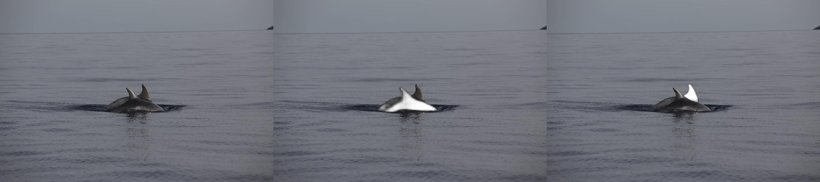

IOU metric: 0.4756197941968153


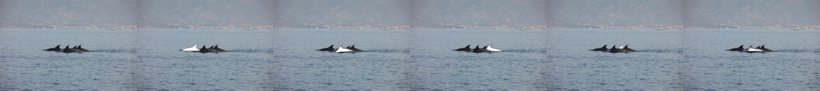

IOU metric: 0.49453726340315735


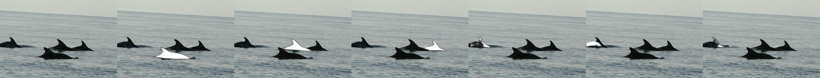

IOU metric: 0.4960627464597811


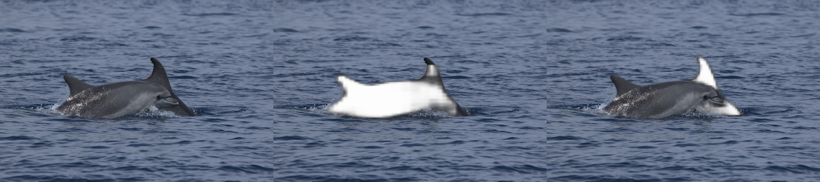

IOU metric: 0.5122488726309984


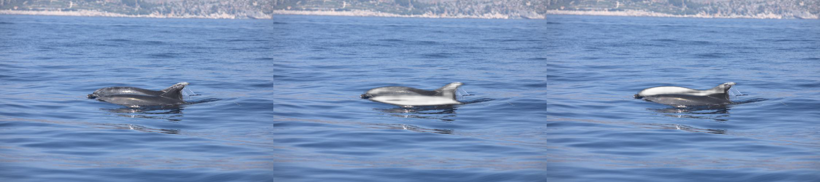

IOU metric: 0.5125102391690628


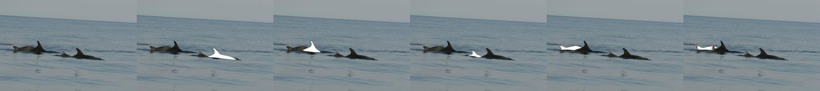

IOU metric: 0.5155329752183607


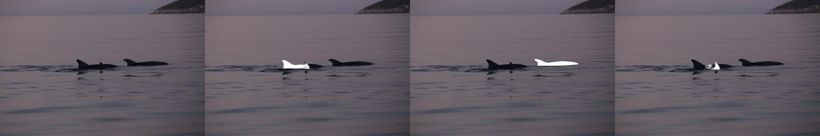

IOU metric: 0.5251719540545396


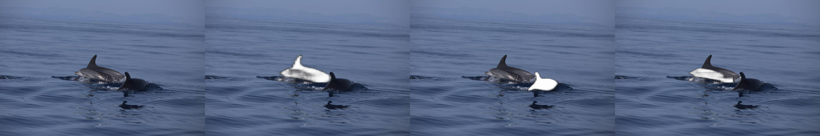

IOU metric: 0.5573696303945055


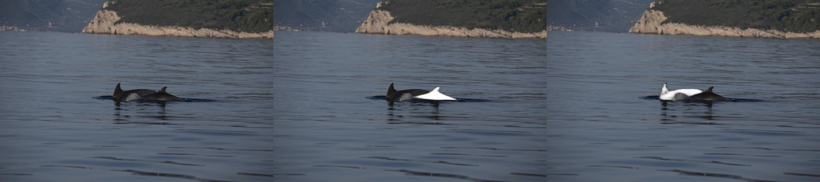

IOU metric: 0.5738050562126649


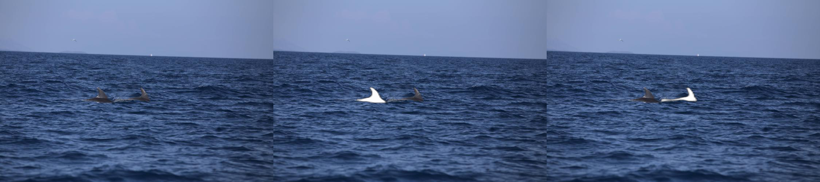

IOU metric: 0.5869603948990534


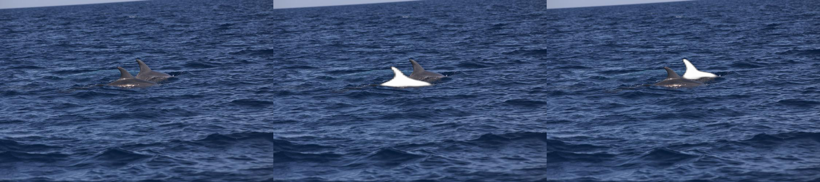

IOU metric: 0.611417860986359


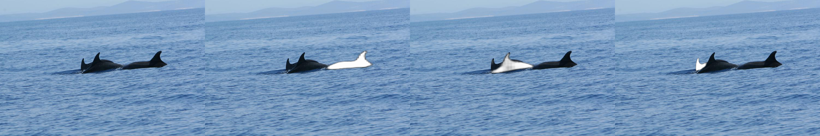

IOU metric: 0.6266646179274642


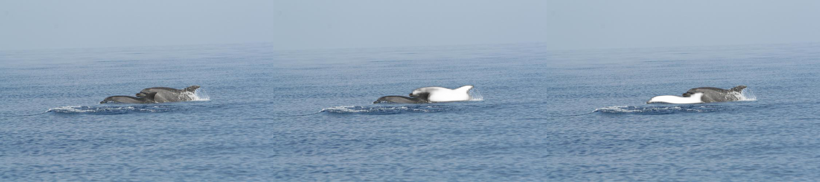

IOU metric: 0.637678156040616


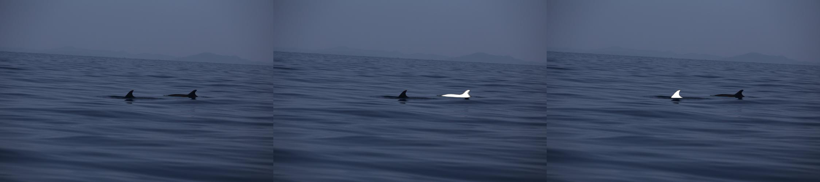

IOU metric: 0.6507437603698991


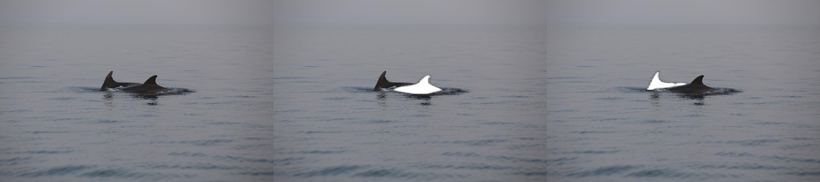

IOU metric: 0.6708286594422596


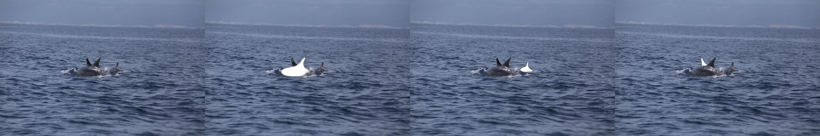

IOU metric: 0.6766911894228075


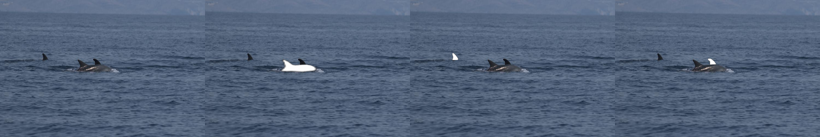

IOU metric: 0.7462771840380762


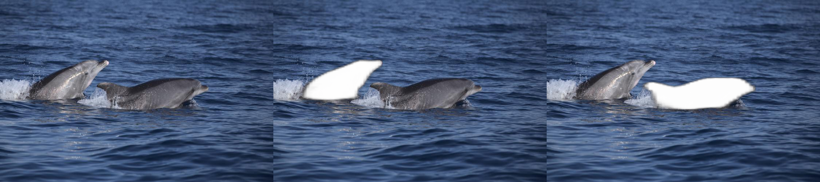

In [ ]:
show_predictions_sorted_by_iou(model, data_loader_test.dataset)

## Submit solution

Here we can see how to use the `submit_model` function. We must pass trained model, an alias that will be displayed on the leaderboard, name and email. Returns the path to the zipped file. 

In [ ]:
from dolphins_recognition_challenge.submissions import submit_model

zip_fname = submit_model(model, alias="dolphin123", name="Name Surname", email="name.surname@gmail.com")

Here we can check what is in the zip file. The zip file contains the model and 2 csv files. The first CSV file contains the iou metrics for each image from the validation set, and the second file contains information about the competitor.

In [ ]:
!unzip -vl "{zip_fname}"

Archive:  submission-iou=0.45722-dolphin123-name.surname@gmail.com-2021-01-04T09:17:55.902567.zip
 Length   Method    Size  Cmpr    Date    Time   CRC-32   Name
--------  ------  ------- ---- ---------- ----- --------  ----
    3356  Stored     3356   0% 2021-01-04 09:17 9cb3fed7  submission-iou=0.45722-dolphin123-name.surname@gmail.com-2021-01-04T09:17:55.902567/metrics.csv
176247136  Stored 176247136   0% 2021-01-04 09:17 136b4c88  submission-iou=0.45722-dolphin123-name.surname@gmail.com-2021-01-04T09:17:55.902567/model.pt
      93  Stored       93   0% 2021-01-04 09:17 30e1f561  submission-iou=0.45722-dolphin123-name.surname@gmail.com-2021-01-04T09:17:55.902567/info.csv
--------          -------  ---                            -------
176250585         176250585   0%                            3 files
